In [1]:
from ticker import Ticker, perform_regression
from yfinance_utils import fetch_stock_data, get_sp500_data, parallelize_fetch
from tqdm import tqdm
import polars as pl
import numpy as np


Data is outdated, fetch new data. Last updated date: 2025-04-03


In [2]:
import pickle
from multiprocessing import Pool
from datetime import date 

def get_ticker_data(ticker):
    return ticker, fetch_stock_data(ticker, start_date='2022-01-01', end_date=date.today().strftime('%Y-%m-%d'))


def parallelize_fetch(tickers, output_file='stock_data.pkl', read_cache=False):
    if read_cache:
        with open(output_file, 'rb') as f:
            return pickle.load(f)
    else:
        with Pool() as pool:
            results = dict(list(tqdm(
                pool.imap(get_ticker_data, tickers),
                total=len(tickers),
                desc="Fetching stock data"
            )))

        
        with open(output_file, 'wb') as f:
            pickle.dump(results, f)
    
    return results

sp500 = get_sp500_data()['Symbol'].to_list() + ['^SPX']
tickers_data = parallelize_fetch(sp500, 'stock_data.pkl', read_cache=False)
from copy import deepcopy
tickers_data_copy = deepcopy(tickers_data)
for k,v in tickers_data_copy.items():
    if len(v) != len(tickers_data['AAPL']):
        print(f"Removing {k} from data")
        del tickers_data[k]
with open('stock_data.pkl', 'wb') as f:
    pickle.dump(tickers_data, f)
    

YF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to True

Fetching stock data:   0%|          | 0/504 [00:00<?, ?it/s]

YF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to True
YF.download() has changed argument auto_adjust default to True
YF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to True


YF.download() has changed argument auto_adjust default to True




Fetching stock data:   2%|▏         | 10/504 [00:04<02:36,  3.15it/s]
1 Failed download:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2022-01-01 -> 2025-04-15)')
Fetching stock data:  11%|█         | 56/504 [00:05<00:20, 22.32it/s]
1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
Fetching stock data: 100%|██████████| 504/504 [00:17<00:00, 29.57it/s]


Removing BRK.B from data
Removing BF.B from data
Removing CEG from data
Removing GEHC from data
Removing GEV from data
Removing KVUE from data
Removing SW from data
Removing SOLV from data
Removing VLTO from data


In [3]:
tickers_data = {ticker: Ticker(ticker).get_momentum().get_market_beta() for ticker in tqdm(Ticker.DATA_DICT.keys())}


100%|██████████| 495/495 [00:00<00:00, 587.00it/s]


In [4]:
tickers_data

{'MMM': <ticker.Ticker at 0x72f846567a10>,
 'AOS': <ticker.Ticker at 0x72f845e30cd0>,
 'ABT': <ticker.Ticker at 0x72f845e311d0>,
 'ABBV': <ticker.Ticker at 0x72f846611940>,
 'ACN': <ticker.Ticker at 0x72f8466122c0>,
 'ADBE': <ticker.Ticker at 0x72f8f1241c70>,
 'AMD': <ticker.Ticker at 0x72f8465a3790>,
 'AES': <ticker.Ticker at 0x72f8465a3240>,
 'AFL': <ticker.Ticker at 0x72f847769350>,
 'A': <ticker.Ticker at 0x72f8465ee350>,
 'APD': <ticker.Ticker at 0x72f8ec716d50>,
 'ABNB': <ticker.Ticker at 0x72f8ec7166c0>,
 'AKAM': <ticker.Ticker at 0x72f845e52190>,
 'ALB': <ticker.Ticker at 0x72f845e52510>,
 'ARE': <ticker.Ticker at 0x72f8ec30c120>,
 'ALGN': <ticker.Ticker at 0x72f8465d9e50>,
 'ALLE': <ticker.Ticker at 0x72f8465d9fd0>,
 'LNT': <ticker.Ticker at 0x72f8469a2200>,
 'ALL': <ticker.Ticker at 0x72f83bf10730>,
 'GOOGL': <ticker.Ticker at 0x72f847bb1a90>,
 'GOOG': <ticker.Ticker at 0x72f845e927b0>,
 'MO': <ticker.Ticker at 0x72f8465f19a0>,
 'AMZN': <ticker.Ticker at 0x72f8465f2960>,
 'AM

In [5]:
def calc_mom (ticker, p1 ,p2):
    date = tickers_data_copy[ticker][p1:p2][-1]['date']
    Y = np.log(pl.DataFrame(tickers_data_copy[ticker])[p1:p2]['close_price'].to_numpy())
    X = np.array(range(1, len(Y)+1))
    model = perform_regression(X, Y)
    score = model.rsquared
    momentum = model.params[1] * score * 252
    return {"date": date, ticker: momentum}

In [6]:
def get_momentum(ticker):
    return [calc_mom(ticker,p1,p2) for p1, p2 in [(i, i+90) for i in range(0, len(tickers_data_copy[ticker])-90)]]

In [7]:
with Pool() as pool:
    results = list(tqdm(
        pool.imap(get_momentum, tickers_data_copy.keys()),
        total=len(tickers_data_copy.keys()),
        desc="Parallelizing momentum calculation"
    ))

Parallelizing momentum calculation: 100%|██████████| 504/504 [00:19<00:00, 25.91it/s]


In [8]:
from functools import reduce
df = reduce(lambda x, y: x.join(y, on='date', how='left'), [pl.DataFrame(result) for result in results if len(result)])
rogue_cols = df.unpivot().filter(pl.col('value').is_null())['variable'].unique().to_list()
df = df.drop(rogue_cols)

In [9]:
def create_momentum_factor (arr, filter_func=None):
    if filter_func:
        arr = filter_func(arr)
    arr = np.sort(arr)
    indices = [int(len(arr) * i/10) for i in range(1, 11)]    
    sum_by_decile = np.array([np.sum(arr[indices[i]:indices[i+1]]) for i in range(0, len(indices)-1)])
    return sum_by_decile[-3:].mean() - sum_by_decile[:3].mean()

In [10]:
momentum = np.array([create_momentum_factor(np.array(x[1:])) for x in df.iter_rows()])
momentum = (momentum / momentum[0]) * 100

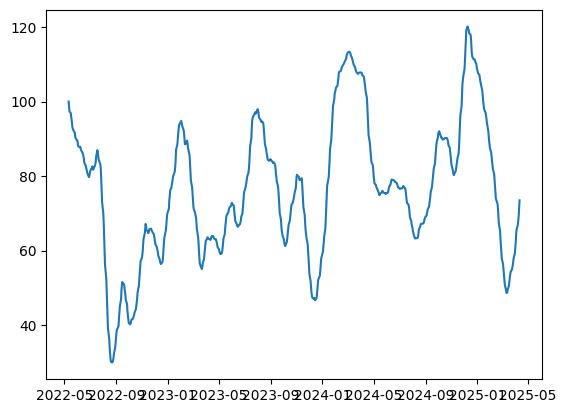

In [11]:
import matplotlib.pyplot as plt
momentum = pl.DataFrame({'date': df['date'], 'momentum': momentum})
plt.plot(momentum['date'], momentum['momentum'])

In [12]:
df[-1].drop('date').unpivot(variable_name='ticker', value_name='momentum').filter(pl.col('momentum')>0).sort('momentum', descending=True)[:10]

ticker,momentum
str,f64
"""CVS""",0.860054
"""VRSN""",0.764859
"""PM""",0.683645
"""EXC""",0.663643
"""T""",0.56884
"""GILD""",0.541013
"""ED""",0.4737
"""NEM""",0.459928
"""RSG""",0.428958


In [13]:
sp500 = get_sp500_data()['Symbol'].to_list()
tickers_data = {ticker: Ticker(ticker).get_momentum().get_market_beta() for ticker in tqdm(Ticker.DATA_DICT.keys())}

100%|██████████| 495/495 [00:00<00:00, 698.19it/s]


In [14]:
import pickle
with open('tickers.pkl', 'wb') as f:
    pickle.dump(tickers_data, f)

In [15]:
momentum = pl.DataFrame({
    "ticker": list(tickers_data.keys()),
    "momentum": [tickers_data[ticker].momentum for ticker in tickers_data.keys()],
    "alpha": [tickers_data[ticker].alpha['coef'] for ticker in tickers_data.keys()]
}).sort('alpha', descending=True)[:7]['ticker'].to_list()

In [16]:

sp500 = sp500[sp500.index.is_in(momentum)]

AttributeError: 'builtin_function_or_method' object has no attribute 'is_in'

In [17]:
def calculate_moving_average(data, window=100):
    return list(map(
        lambda i: sum(data[i:i+window]) / window, 
        range(len(data) - window + 1)
    ))

In [18]:
# plt.plot(tickers_data['^SPX'].price)
calculate_moving_average(tickers_data['^SPX'].price)

[np.float64(4370.842893066406),
 np.float64(4363.455693359375),
 np.float64(4357.1026953125),
 np.float64(4351.418393554687),
 np.float64(4345.4701953125),
 np.float64(4340.468095703125),
 np.float64(4334.850595703125),
 np.float64(4328.93419921875),
 np.float64(4323.2775),
 np.float64(4317.84490234375),
 np.float64(4311.394602050781),
 np.float64(4304.632104492188),
 np.float64(4296.800805664063),
 np.float64(4289.328305664062),
 np.float64(4283.248806152344),
 np.float64(4275.815207519531),
 np.float64(4268.9991064453125),
 np.float64(4263.147705078125),
 np.float64(4257.481506347656),
 np.float64(4251.120305175781),
 np.float64(4245.08220703125),
 np.float64(4238.617907714844),
 np.float64(4230.939609375),
 np.float64(4224.353510742188),
 np.float64(4217.20201171875),
 np.float64(4210.616611328125),
 np.float64(4203.715109863281),
 np.float64(4196.294108886719),
 np.float64(4190.279509277344),
 np.float64(4185.086906738281),
 np.float64(4179.614506835937),
 np.float64(4173.091809082

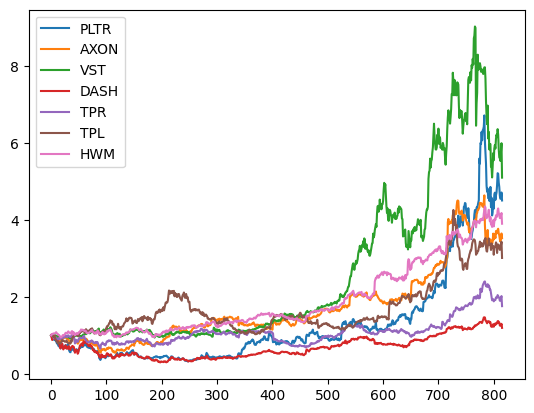

In [19]:
import matplotlib.pyplot as plt

for ticker in momentum:
    prices = tickers_data[ticker].price 
    rescaled_prices = prices / prices[0]
    plt.plot(rescaled_prices, label=ticker)

plt.legend()


In [ ]:
w.calculate_momentum(strategy='ols')